Pair Programming Decision Tree - 11

En el pair programming de hoy debéis usar el csv que guardastéis cuando hicistéis el pairprgramming de codificicación (este csv debería tener las variables estadandarizas).
En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal. El objetivo de hoy es:
  - Ajustar el modelo a un Decision Tree
  - Extraer las métricas
  - Debatid entre vosotras que modelo es mejor y por qué (basándose en las métricas)

In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [4]:
df = pd.read_csv('wellness_8.csv', index_col = 0)

In [6]:
df1 = df.copy()
df1.sample(4)

,FRUITS_VEGGIES,DAILY_STRESS,CORE_CIRCLE,SOCIAL_NETWORK,BMI_RANGE,DAILY_STEPS,SLEEP_HOURS,SUFFICIENT_INCOME,TIME_FOR_PASSION,WEEKLY_MEDITATION,AGE,GENDER,WORK_LIFE_BALANCE_SCORE,WORK_LIFE_BALANCE_SCORE_RAIZ,AGE_le,owners_Female,owners_Male
5736,1,0,0,5,2,2,7,2,0,7,0,Male,629.3,25.085853,3,0,1
13811,1,4,3,10,2,3,7,2,2,6,1,Female,629.5,25.089839,0,1,0
9638,2,4,6,10,2,7,6,2,2,3,2,Female,681.1,26.097893,1,1,0
14712,4,3,2,10,2,4,7,2,2,7,2,Female,639.9,25.296245,1,1,0


In [ ]:
df1 = df1.drop(['GENDER', 'WORK_LIFE_BALANCE_SCORE'], axis = 1, inplace = True)

# Preparamos los datos

In [12]:
# Separamos nuestro dataframe en X e y

X = df1.drop('WORK_LIFE_BALANCE_SCORE_RAIZ', axis = 1)
y = df1['WORK_LIFE_BALANCE_SCORE_RAIZ']

In [13]:
 # dividimos nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Ajustamos el modelo

In [14]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lineal. 
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [ ]:
# con entrenado el arbol, usamos la función plot_tree() dibuja la estructura del árbol y muestra el número de observaciones y valor medio de la variable respuesta en cada nodo.

fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
plt.show()

In [15]:
#
# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 4. 

max_features = np.sqrt(len(x_train.columns))
max_features

3.872983346207417

In [16]:
# max depth

print(arbol.tree_.max_depth)

20


In [17]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [18]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [19]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,3.172291e-04,1.298802e-05,3.603889e-03,0.999983,test,Decission Tree I
1,2.654947e-15,1.939096e-29,4.403517e-15,1.000000,train,Decission Tree I


--> En train => métricas más bajas : R2 más alto : '***overfitting*** => nuestro modelo está aprendiendo de memoria los datos de entrenamiento y no será capaz de predecir bien con nuevos datos.
- Si*overfitting* => reducir la profundidad del modelo

In [20]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [2, 4, 6, 8, 10], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [50,100,150, 200, 300, 400, 500],
        "min_samples_leaf": [50,100,150, 200, 300, 400, 500]} 

In [21]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva


In [22]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [50, 100, 150, 200, 300, 400, 500],
                         'min_samples_split': [50, 100, 150, 200, 300, 400,
                                               500]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [29]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 variables predictoras para construir el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=8, max_features=4, min_samples_leaf=100,
                      min_samples_split=200)

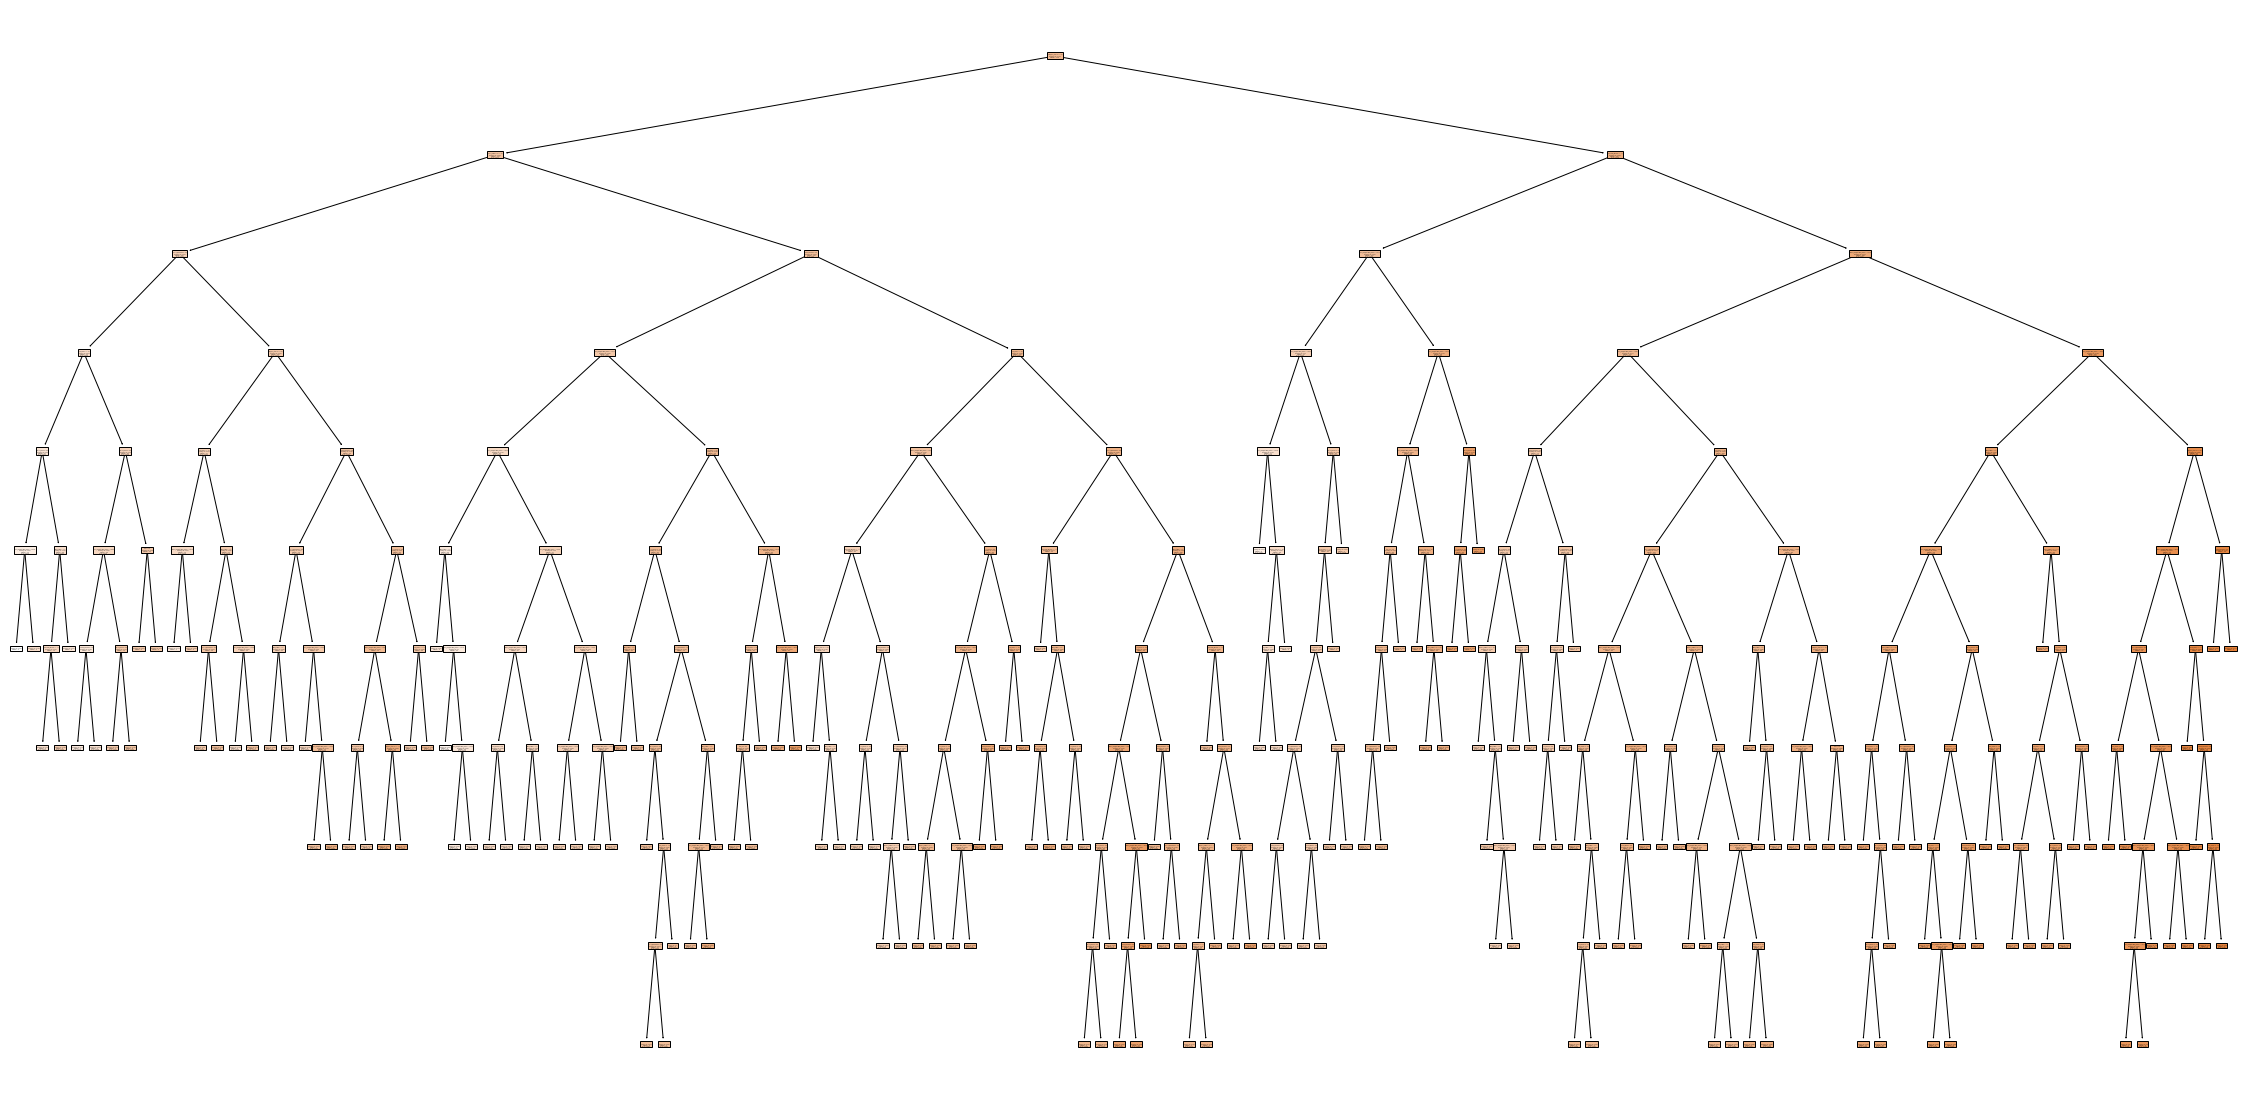

In [ ]:
fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

- Calculamos las métricas
  - (Comprobamos si la predicción es válida)

In [30]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [31]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,0.220747,0.096938,0.311348,0.872066,test,Decision tree II
1,0.218369,0.094960,0.308157,0.876466,train,Decision tree II


In [32]:
# juntamos los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,3.172291e-04,1.298802e-05,3.603889e-03,0.999983,test,Decission Tree I
1,2.654947e-15,1.939096e-29,4.403517e-15,1.000000,train,Decission Tree I
0,2.207468e-01,9.693751e-02,3.113479e-01,0.872066,test,Decision tree II
1,2.183687e-01,9.496048e-02,3.081566e-01,0.876466,train,Decision tree II


In [25]:
# juntaos el csv de metricas (pprog 10 ) con los resultados de hoy:

df10 = pd.read_csv('/content/wellness_resultados_10', index_col = 0)

In [33]:
df_dtree_results = pd.concat([df10, df_decision_results], axis = 0)
df_dtree_results

,MAE,MSE,RMSE,R2,set,modelo
0,1.373714e-02,3.948336e-04,1.987042e-02,0.999479,test,Linear Regresion
1,1.397905e-02,4.173375e-04,2.042884e-02,0.999457,train,LinearRegression
0,3.172291e-04,1.298802e-05,3.603889e-03,0.999983,test,Decission Tree I
1,2.654947e-15,1.939096e-29,4.403517e-15,1.000000,train,Decission Tree I
0,2.207468e-01,9.693751e-02,3.113479e-01,0.872066,test,Decision tree II
1,2.183687e-01,9.496048e-02,3.081566e-01,0.876466,train,Decision tree II


- Vemos la importancia de cada variable  

In [34]:
# creamos un dataframe para la importancia:
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
11,WORK_LIFE_BALANCE_SCORE,5.492522e-01
0,FRUITS_VEGGIES,1.754789e-01
2,CORE_CIRCLE,1.681014e-01
7,SUFFICIENT_INCOME,5.701098e-02
9,WEEKLY_MEDITATION,1.713289e-02
3,SOCIAL_NETWORK,1.598799e-02
5,DAILY_STEPS,6.201593e-03
4,BMI_RANGE,5.218670e-03
8,TIME_FOR_PASSION,3.431472e-03
1,DAILY_STRESS,1.988539e-03


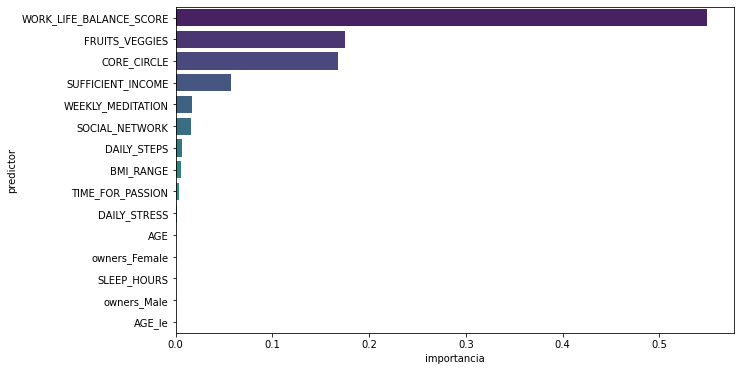

In [35]:
# ploteamos el resultado para su visualización: 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

In [36]:
df_dtree_results.to_csv('wellness_11.csv')